In [2]:
#%%
from array import array
from cmath import nan
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torchvision
import torchvision.transforms as transforms
from itertools import chain
from sklearn import metrics as met
import pickle
import icecream as ic
import torchsummary
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
import util
from torchmetrics import Accuracy
from torch.utils.data.datapipes.datapipe import _IterDataPipeSerializationWrapper, _MapDataPipeSerializationWrapper
from torch.utils.data import default_convert
from tqdm import tqdm


/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seqs_df, res_all = util.load_data.get_main_dataset()
N_samples = seqs_df.shape[0]
DRUGS = util.DRUGS
LOCI = seqs_df.columns
assert set(DRUGS) == set(res_all.columns)
N_drugs = len(DRUGS)

# load the CRyPTIC samples as test data
seqs_cryptic, res_cryptic = util.load_data.get_cryptic_dataset()
# make sure the loci are in the same order as in the training data
seqs_cryptic = seqs_cryptic[seqs_df.columns]

In [4]:
def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


class Model(nn.Module):
    def __init__(
        self,
        in_channels=4,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        self.conv_layers = nn.ModuleList(
            self._conv_layer(num_filters, num_filters, 3)
            for _ in range(num_conv_layers)
        )
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.Sigmoid()) #difference between sequential and nn.moduleList?
        )

    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x = self.prediction_layer(x)
        return x
    


In [5]:
missing_res = set(res_all.columns).difference(res_cryptic.columns)
miss_df = pd.DataFrame(columns=missing_res)
res_cryptic1 = pd.concat([res_cryptic, miss_df])
res_cryptic1 = res_cryptic1[res_all.columns]

#%%
#creating eval Dataloader
LOCI = seqs_cryptic.columns
DRUGS = res_all.columns

class OneHotSeqsDataset_val(torch.utils.data.Dataset):
    def __init__(
        self,
        seq_cryptic,
        res_cryptic,
        target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
    ):
        self.seq_cryptic = seq_cryptic[target_loci]
        self.res_cryptic = res_cryptic[target_drugs]
        if not self.seq_cryptic.index.equals(self.res_cryptic.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_cryptic.iloc[index].str.cat()
            res = self.res_cryptic.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_cryptic.loc[index].str.cat()
            res = self.res_cryptic.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res_cryptic.shape[0]

dataset = OneHotSeqsDataset_val(seqs_cryptic, res_cryptic1, one_hot_dtype=torch.float)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=collate_padded_batch
)



In [6]:
# AUC calculation
from torchmetrics import AUROC

def auc_func(preds, y_stack):
    res_index = [res_all.columns.tolist().index(x) for x in res_cryptic.columns.tolist()]
    dr_cryptic = ['ISONIAZID','RIFAMPICIN','ETHAMBUTOL','AMIKACIN','KANAMYCIN','MOXIFLOXACIN','LEVOFLOXACIN','ETHIONAMIDE']
    y_stack =  torch.cat(y_, dim=0)
    y_select =  y_stack[:, res_index]

    preds_stack = torch.cat(preds, dim=0)
    preds_select = preds_stack[:, res_index]
    auc_dict = {}
    for x in range(y_select.size()[1]):
        no_nan = ~y_select[:,x].isnan()
        pred_masked = preds_select[:,x][no_nan].to(device)
        y_masked = y_select[:,x][no_nan].to(device)
        # ic(pred_masked, y_masked)
        # ic(len(pred_masked), len(y_masked))
        auroc = AUROC(pos_label=1)
        auc = auroc(pred_masked, y_masked.int())
        auc = auc.cpu().numpy().tolist()
        auc_dict[dr_cryptic[x]] = auc 
    return auc_dict

def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.annotate(y_list[i-1],(i-1,y_list[i-1]),ha="center")
#plotting auc
def auc_plot(name, auc_dict):
    # plt.bar(*zip(*auc_dict.items()))
    # plt.ylim(0,1)
    # plt.xticks(rotation = 45)
    # plt.title(f'AUC_{name}')
    # for i, v in enumerate(auc_dict.values):
    #     plt.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    fig, ax = plt.subplots()
    ax.bar(auc_dict.keys(), auc_dict.values())
    ax.tick_params(axis='x', labelrotation = 45)
    add_value_label(list(auc_dict.keys()),[round(x,2) for x in list(auc_dict.values())])
    ax.set_xlabel("Drug resistances")
    ax.set_ylabel("AUC")
    ax.set_ylim(0,1)
    ax.set_title(f'AUC_{name}-avg-{np.mean(list(auc_dict.values()))}')
    fig.tight_layout()
    fig.show()
    


<h3>Full model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5           [-1, 128, 49976]               0
            Conv1d-6           [-1, 128, 49974]          49,280
       BatchNorm1d-7           [-1, 128, 49974]             256
              ReLU-8           [-1, 128, 49974]               0
           Dropout-9           [-1, 128, 49974]               0
           Conv1d-10           [-1, 128, 49972]          49,280
      BatchNorm1d-11           [-1, 128, 49972]             256
             ReLU-12           [-1, 128, 49972]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

100%|██████████| 1051/1051 [00:51<00:00, 20.59it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


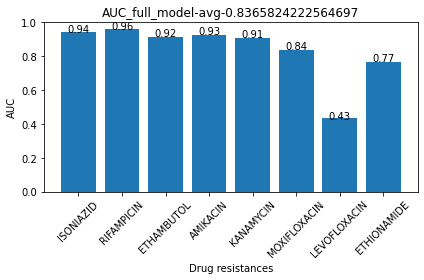

In [83]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=2,
    num_dense_neurons=64,
    num_dense_layers=3,
    return_logits=True,
).to(device)
m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
# print('-----------------------')

auc_dict = auc_func(preds, y_)
auc_plot('full_model', auc_dict)


<h3>Reduced Model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
      BatchNorm1d-11                   [-1, 64]             128
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 13]             845
Total params: 26,701
Trainable params: 

100%|██████████| 1051/1051 [00:38<00:00, 27.45it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


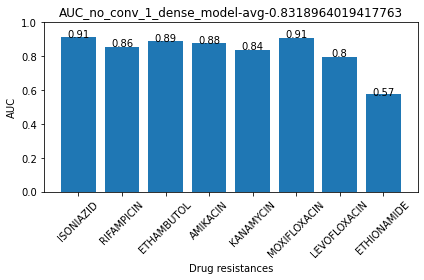

In [84]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=2,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model_0c2d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
# print('-----------------------')

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_1_dense_model', auc_dict)

<h3>Reduce reduce model - dropping all dense layers

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:36<00:00, 28.66it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


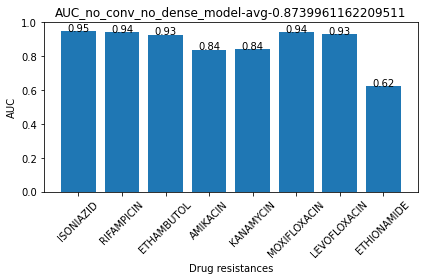

In [85]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_model', auc_dict)

<h3>Reduce reduce reduce model 64 filter instead of 128

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2            [-1, 64, 49976]           6,464
       BatchNorm1d-3            [-1, 64, 49976]             128
              ReLU-4            [-1, 64, 49976]               0
           Dropout-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 11,725
Trainable params: 11,725
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 74.73
Params size (MB): 0.04
Estimated Total Size (MB): 75.54
-------------------------------------------

100%|██████████| 1051/1051 [00:34<00:00, 30.42it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


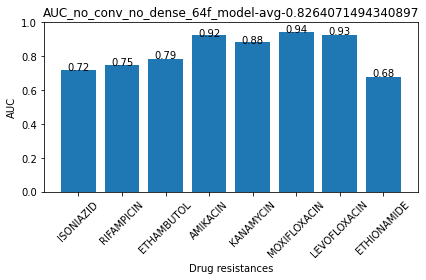

In [86]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=64,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d64f.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_64f_model', auc_dict)

<h3>decreasing number of filters and neurons

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2            [-1, 32, 49976]           3,232
       BatchNorm1d-3            [-1, 32, 49976]              64
              ReLU-4            [-1, 32, 49976]               0
           Dropout-5                   [-1, 32]               0
            Linear-6                   [-1, 32]           1,056
       BatchNorm1d-7                   [-1, 32]              64
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 13]             429
Total params: 4,845
Trainable params: 4,845
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 38.13
Params size (MB): 0.02
Estimated Total Size (MB): 38.91
---------------------------------------------

100%|██████████| 1051/1051 [00:34<00:00, 30.67it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


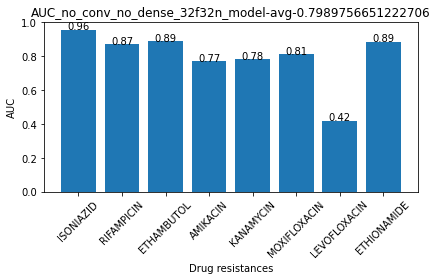

In [87]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=32,
    num_conv_layers=0,
    num_dense_neurons=32,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d32f32n.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_32f32n_model', auc_dict)

<h3>again decreasing number of filters and neurons

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2             [-1, 8, 49976]             808
       BatchNorm1d-3             [-1, 8, 49976]              16
              ReLU-4             [-1, 8, 49976]               0
           Dropout-5                    [-1, 8]               0
            Linear-6                    [-1, 8]              72
       BatchNorm1d-7                    [-1, 8]              16
              ReLU-8                    [-1, 8]               0
            Linear-9                   [-1, 13]             117
Total params: 1,029
Trainable params: 1,029
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 10.68
Params size (MB): 0.00
Estimated Total Size (MB): 11.44
---------------------------------------------

100%|██████████| 1051/1051 [00:33<00:00, 31.14it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


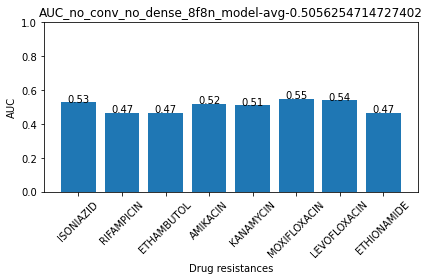

In [89]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=8,
    num_conv_layers=0,
    num_dense_neurons=8,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d8f8n.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_8f8n_model', auc_dict)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2            [-1, 16, 49976]           1,616
       BatchNorm1d-3            [-1, 16, 49976]              32
              ReLU-4            [-1, 16, 49976]               0
           Dropout-5                   [-1, 16]               0
            Linear-6                   [-1, 16]             272
       BatchNorm1d-7                   [-1, 16]              32
              ReLU-8                   [-1, 16]               0
            Linear-9                   [-1, 13]             221
Total params: 2,173
Trainable params: 2,173
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 19.83
Params size (MB): 0.01
Estimated Total Size (MB): 20.60
---------------------------------------------

100%|██████████| 1051/1051 [00:34<00:00, 30.52it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_49739/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


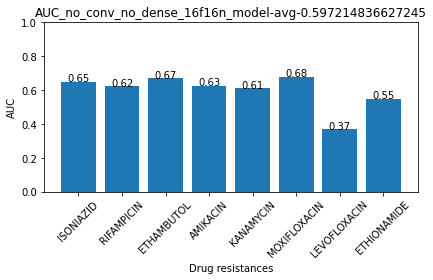

In [91]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=16,
    num_conv_layers=0,
    num_dense_neurons=16,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d16f16n.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

16f16n - with batch size 16
<br>scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2            [-1, 16, 49976]           1,616
       BatchNorm1d-3            [-1, 16, 49976]              32
              ReLU-4            [-1, 16, 49976]               0
           Dropout-5                   [-1, 16]               0
            Linear-6                   [-1, 16]             272
       BatchNorm1d-7                   [-1, 16]              32
              ReLU-8                   [-1, 16]               0
            Linear-9                   [-1, 13]             221
Total params: 2,173
Trainable params: 2,173
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 19.83
Params size (MB): 0.01
Estimated Total Size (MB): 20.60
---------------------------------------------

100%|██████████| 1051/1051 [00:34<00:00, 30.71it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_101065/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


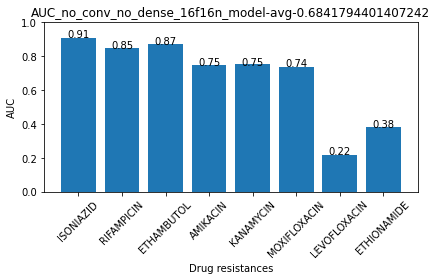

In [7]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=16,
    num_conv_layers=0,
    num_dense_neurons=16,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_16f16n-50e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

32f32n

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2            [-1, 32, 49976]           3,232
       BatchNorm1d-3            [-1, 32, 49976]              64
              ReLU-4            [-1, 32, 49976]               0
           Dropout-5                   [-1, 32]               0
            Linear-6                   [-1, 32]           1,056
       BatchNorm1d-7                   [-1, 32]              64
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 13]             429
Total params: 4,845
Trainable params: 4,845
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 38.13
Params size (MB): 0.02
Estimated Total Size (MB): 38.91
---------------------------------------------

100%|██████████| 1051/1051 [00:36<00:00, 29.10it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_101065/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


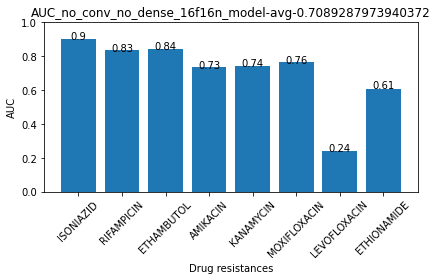

In [8]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=32,
    num_conv_layers=0,
    num_dense_neurons=32,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_32f32n-20e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

128f64n

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:35<00:00, 29.46it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_101065/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


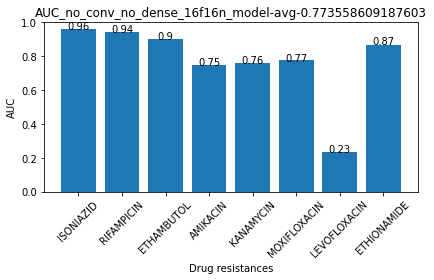

In [9]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_128f64n-20e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:34<00:00, 30.44it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_101065/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


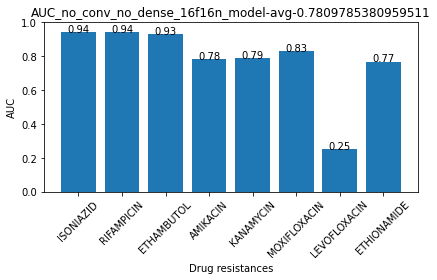

In [10]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_128f64n-20e1'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

128f64n with all data

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:35<00:00, 29.87it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_101065/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


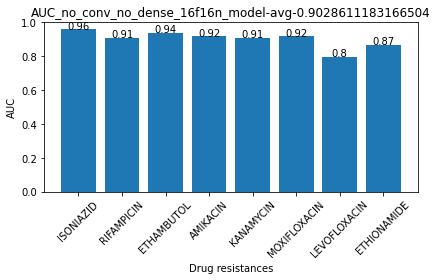

In [12]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_128f64n_model', auc_dict)